Continued from Modeling and Evaluation

In the previous part, we explored two ways of performing dimensionality reduction on the first 1139 columns of data matrix. In this part, we will perform the feature engieering on the first 116 categorical features as  described in the exploratory data analysis https://github.com/chao-ji/allstate_severity/blob/master/Exploratory%20Data%20Analysis.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

We will turn the categorical labels into the average of the target values of each group that contains instances with the same label.

That is, **SELECT LABEL, AVG(TARGET) FROM TABLE GROUP BY LABEL**

In [2]:
train = pd.read_csv("train.csv")
y = train["loss"]
train = train.ix[:, 1:-1]

We apply this feature engineering on all categorical variables, if the number of unique labels is at least 4:

In [3]:
train_msged = pd.DataFrame()

threshold = 4
for i in range(116):
    if train.ix[:, i].unique().size <= threshold:
        cat_msged = pd.get_dummies(train["cat" + str(i + 1)], prefix="cat" + str(i + 1))
    else:
        mean= y.groupby(train.ix[:, i]).mean()
        mean = mean.sort_values()
        mean /= mean.sum()
        cat_msged = train.ix[:, i].map(lambda x: mean[x])
    
    train_msged = pd.concat([train_msged, cat_msged], axis=1)

# Combine with the continuous features    
train_msged = pd.concat([train_msged, train.ix[:, "cont1" : "cont14"]], axis=1)    

In [4]:
X, y = train_msged.values, y.values

The number of features is reduced from 1153 down to 246:

In [5]:
X.shape

(188318, 246)

Split X and y into training and test

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

del X, y

Train an ensemble of 50 MultiLayer Perceptron

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
mlpr_ensemble = BaggingRegressor(MLPRegressor(hidden_layer_sizes=(100,)), n_estimators=50, n_jobs=2)

pl = Pipeline(steps=[("scaler", scaler),
                     ("est", mlpr_ensemble)])

Functions to convert target value **y** between linear scale and log scale

In [8]:
def log1p(x, base=10.):
    return np.log(x + 1) / np.log(base)

def expm1(x, base=10.):
    return base**x - 1.

In [9]:
pl.fit(X_train, log1p(y_train))

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('est', BaggingRegressor(base_estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate=...estimators=50, n_jobs=2, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])

Performance is slightly better than using one-hot encoding and then applying feature agglomeration or truncated SVD

In [10]:
y_pred = expm1(pl.predict(X_test))

mean_absolute_error(y_test, y_pred)

1164.6356345996417

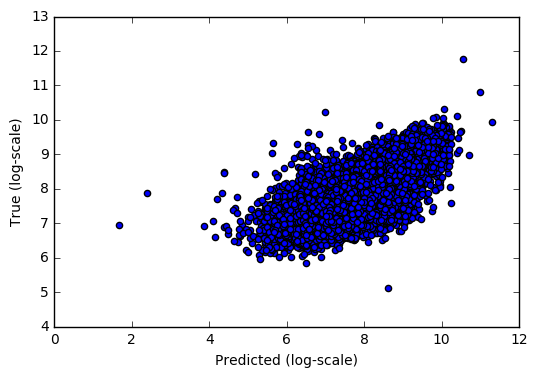

In [11]:
plt.scatter(np.log(y_test), np.log(y_pred), linewidths=1.0)
plt.xlabel("Predicted (log-scale)")
plt.ylabel("True (log-scale)")
plt.show()